# Algotytm przecinania się odcinków na płaszczyźnie

In [ ]:
import numpy as np
import pandas as pd
from bitalg.tests.test4 import Test
from bitalg.visualizer.main import Visualizer
import matplotlib.pyplot as plt
from sortedcontainers import SortedSet
import heapq

# Przydatne funkcje 

In [2]:
def draw_example_1():
    vis = Visualizer()
    line_segments = ((-0.5, 0.5), (8.5, 3.5),
                     (1, 3), (7, 5),
                     (2, 4), (5, 1),
                     (4.5, 3), (6.5, 6),
                     (0, 5), (5.5, 5.5))

    vis.add_line_segment(line_segments)
    vis.show()
    
def draw_example_2():
    vis = Visualizer()
    line_segments = ((-0.5, 0.5), (8.5, 3.5),
                     (1, 3), (7, 5),
                     (2, 4), (5, 1),
                     (4.5, 3), (6.5, 6),
                     (0, 5), (5.5, 5.5))
    points = [(4, 2),
              (2.5, 3.5),
              (5.5, 4.5)]

    vis.add_line_segment(line_segments)
    vis.add_point(points, color='red')
    vis.show()


### Wprowadzenie
Celem ćwiczenia jest implementacja i zapoznanie się z algorytmem wyznaczającym wszystkie przecięcia się odcinków na płaszczyźnie

### Przykładowy zbiór odcinków przed wyznaczeniem punktów przecięcia

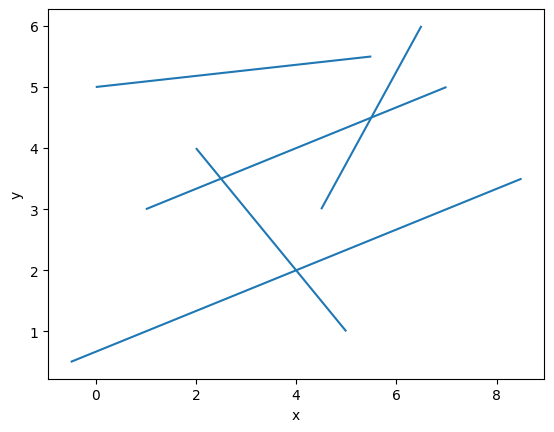

In [3]:
draw_example_1()

### Przykładowy zbiór odcinków po wyznaczenu punktów przecięcia

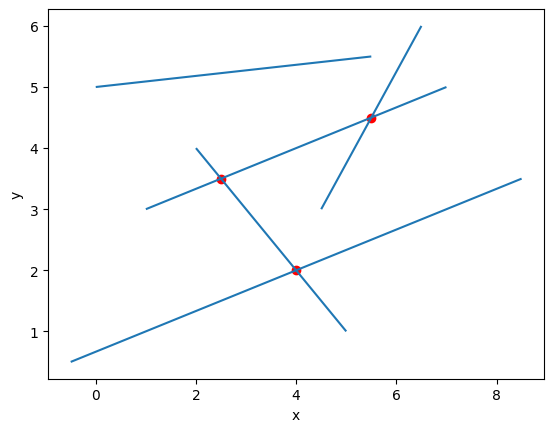

In [4]:
draw_example_2()

Potrzebne ogólne struktury

# Generowanie losowych odcinków na płaszczyźnie

Uzupełnij funkcję ```generate_uniform_sections```

In [3]:
def generate_uniform_sections(max_x, max_y, n):
    """
    Funkcja generuje odcinki o współrzędnych rzeczywistych w postaci par punktów. 
    Żaden wygenerowany odcinek nie jest odcinkiem pionowym.
    Żadne dwa odcinki nie mają swoich końców o takiej samej współrzędnej x.
    Zakres współrzędnych: x -> (0, max_x), y -> (0, max_y)
    :param max_x: określa maksymalną wartość współrzednej x jaka może zostać wylosowana
    :param max_y: określa maksymalną wartość współrzednej y jaka może zostać wylosowana
    :param n: ilość generowanych odcinków
    :return: tablica odcinków w postaci krotek zawierających parę krotek współrzędnych punktów końcowych odcinków
    np. [((x1, y1), (x2, y2)), ((x3, y3), (x4, y4)),...]
    """
    points = []
    set_x = set()
    for _ in range(n):
        x1 = np.random.uniform(0,max_x)
        if x1 in set_x:
            continue
        set_x.add(x1)

        x2 = np.random.uniform(x1,max_x)
        if x2 in set_x:
            continue
        set_x.add(x2)

        y1 = np.random.uniform(0,max_y)
        y2 = np.random.uniform(0,max_y)
        points.append(((x1,y1),(x2,y2)))
    return points

Funkcja generująca zbiór o takich samych długościach odcinków, oraz stałą ilość przecięc dla każdego n

In [ ]:
def generate_uniform_sections_same_length(max_x, max_y, n):
    """
    Funkcja generuje odcinki o współrzędnych rzeczywistych w postaci par punktów. 
    Żaden wygenerowany odcinek nie jest odcinkiem pionowym, a odcinki mają taką samą długość
    Żadne dwa odcinki nie mają swoich końców o takiej samej współrzędnej x.
    Zakres współrzędnych: x -> (0, max_x), y -> (0, max_y)
    :param max_x: określa maksymalną wartość współrzednej x jaka może zostać wylosowana
    :param max_y: określa maksymalną wartość współrzednej y jaka może zostać wylosowana
    :param n: ilość generowanych odcinków
    :return: tablica odcinków w postaci krotek zawierających parę krotek współrzędnych punktów końcowych odcinków
    np. [((x1, y1), (x2, y2)), ((x3, y3), (x4, y4)),...]
    """
    dl=max_x//n*300
    points = []
    set_x = set()
    for _ in range(n):
        x1 = np.random.uniform(0,max_x)
        if x1 in set_x:
            continue
        set_x.add(x1)
        y1 = np.random.uniform(0,max_y)
        fi = np.random.uniform(0,2*np.pi)
        if fi==np.pi/2 or fi==3*np.pi/2:
            continue
        x2 = x1+dl*np.cos(fi)
        if x2 in set_x:
            continue
        y2=y1 + dl*np.sin(fi)
        if x1>x2:
            x1,y1,x2,y2=x2,y2,x1,y1
        points.append(((x1,y1),(x2,y2)))
    return points

In [4]:
Test().runtest(1, generate_uniform_sections)

Lab 4, task 1:
	Test 1: Passed
	Test 2: Passed
	Test 3: Passed
Result: 3/3
Time: 0.126s


<span style="color:red">Ćw.</span> Wygeneruj $\large20$ losowych odcinków w przestrzeni 2D o współrzędnych z przedziału $\large x \in \langle 0,1000 \rangle$ oraz $\large y \in \langle 0,1000\rangle$. 

In [286]:
zbior20 = generate_uniform_sections(1000, 1000, 20)

Zwizualizuj otrzymane odcinki

In [5]:
def draw_only_intersect(line_segments):
    vis = Visualizer()
    vis.add_line_segment(line_segments)
    vis.show()

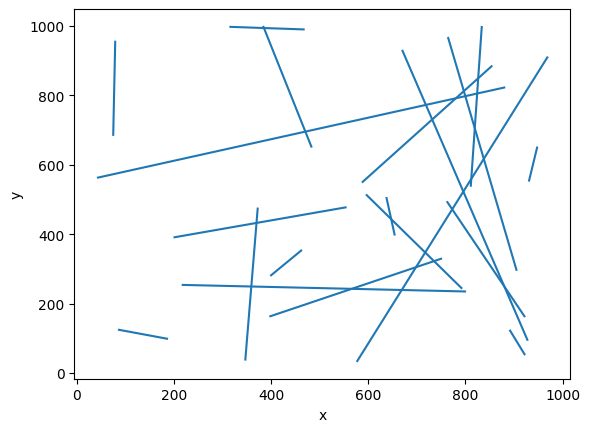

In [287]:
draw_only_intersect(zbior20)

Uzupełnij funkcję ```add_sections``` #interaktywne dodawanie odcinków przez rysowanie myszką

In [22]:
%matplotlib tk
test_fild=[]
class PolygonDrawer:
    def __init__(self):
        self.points = []  # Lista wierzchołków wielokąta
        self.figure, self.ax = plt.subplots()
        self.setup_plot()
        self.bufor=[]
        self.tab_of_section=[]

    def setup_plot(self):
        # Ustawienia wykresu
        self.ax.set_title("Kliknij, aby dodać punkt")
        self.ax.set_xlim(0, 2)  # Zakres osi X
        self.ax.set_ylim(0, 2)  # Zakres osi Y
        self.ax.set_aspect('equal', adjustable='box')
        
        # Podłączanie zdarzeń
        self.cid = self.figure.canvas.mpl_connect('button_press_event', self.on_click)

    def on_click(self, event):
        # Dodanie punktu i odrysowanie wielokąta
        
        if event.button == 1:
            self.draw_point( (event.xdata, event.ydata))
            
            if len(self.bufor)==0:
                self.bufor.append(event.xdata)
                self.bufor.append(event.ydata)
            else:
                self.draw_line(((event.xdata, event.ydata),(self.bufor[0],self.bufor[1])))
                self.tab_of_section.append(((self.bufor[0],self.bufor[1]),(event.xdata, event.ydata)))
                self.bufor=[]
                

        elif event.button == 3:  # PPM zamyka program po dwukliku
            if len(self.tab_of_section) > 0 and event.dblclick:
                self.print_section_tab()
                plt.close(self.figure)
    
    def draw_point(self,point):
        self.ax.scatter(point[0],point[1],color="red", zorder=5)
        self.figure.canvas.draw()

    def draw_line(self,points):
        x=[points[0][0],points[1][0]]
        y=[points[0][1],points[1][1]]
        self.ax.plot(x, y, marker='o', color='blue', linestyle='-', linewidth=2)
        self.figure.canvas.draw()        

    def print_section_tab(self):
        global test_fild
        t2 = []
        for begin, end in self.tab_of_section:
            if begin[0]<end[0]:
                t2.append(((float(begin[0]),float(begin[1])),(float(end[0]),float(end[1]))))
            else:
                t2.append(((float(end[0]),float(end[1])),(float(begin[0]),float(begin[1]))))
        draw_only_intersect(t2)
        print(t2)
        test_fild=t2

if __name__ == "__main__":
    drawer = PolygonDrawer()
    plt.tight_layout()
    plt.ion()
    plt.show()

[((0.3158909391352246, 1.6620765629303218), (1.5651335720187278, 0.6904434040209306)), ((0.3654640594877445, 0.8094188928669785), (1.5502616359129715, 1.6521619388598179)), ((0.49435417240429647, 1.1911319195813823), (0.6629027816028642, 1.2060038556871382)), ((1.0347011842467642, 1.1861746075461304), (1.118975488846048, 1.1960892316166343)), ((1.1338474249518038, 0.7449738364087026), (1.3519691545028918, 1.6868631231065818)), ((1.3222252822913796, 0.6706141558799227), (1.4759019553841917, 1.7810520517763697)), ((1.4511153952079319, 1.1514734232993662), (1.5205177637014597, 1.1663453594051223))]


# Zbiory testujące

Zbior A: mała liczba przecięć

7

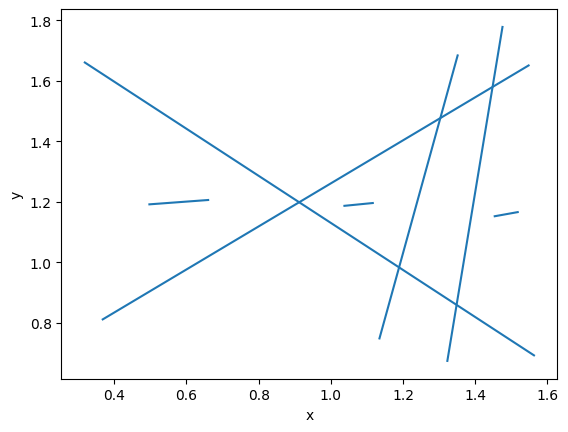

In [288]:
zbiorA=[((0.3158909391352246, 1.6620765629303218), (1.5651335720187278, 0.6904434040209306)), ((0.3654640594877445, 0.8094188928669785), (1.5502616359129715, 1.6521619388598179)), ((0.49435417240429647, 1.1911319195813823), (0.6629027816028642, 1.2060038556871382)), ((1.0347011842467642, 1.1861746075461304), (1.118975488846048, 1.1960892316166343)), ((1.1338474249518038, 0.7449738364087026), (1.3519691545028918, 1.6868631231065818)), ((1.3222252822913796, 0.6706141558799227), (1.4759019553841917, 1.7810520517763697)), ((1.4511153952079319, 1.1514734232993662), (1.5205177637014597, 1.1663453594051223))]
draw_only_intersect(zbiorA)
len(zbiorA)

Zbiór B: duża liczba przecięć

7

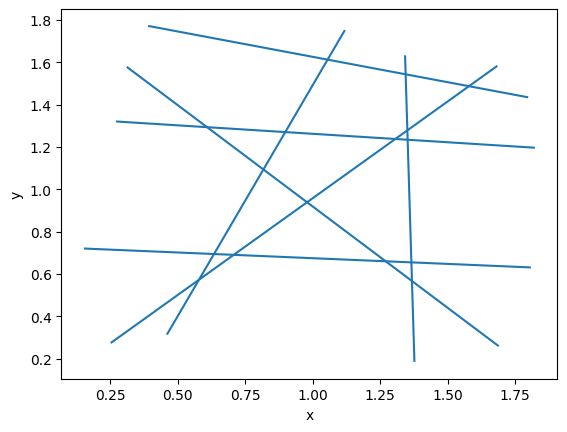

In [7]:
zbiorB=[((0.3109336270999725, 1.577802258331038), (1.6890663729000277, 0.25915725695400704)), ((0.25144588267694856, 0.27402919305976303), (1.6841090608647757, 1.58275957036629)), ((0.1522996419719087, 0.7201872762324426), (1.8080418617460756, 0.6309556595979067)), ((0.2712751308179566, 1.3200220324979342), (1.8229137978518315, 1.1960892316166343)), ((0.4596529881575325, 0.31368768934177893), (1.118975488846048, 1.7513081795648577)), ((1.3420545304323879, 1.6323326907188098), (1.3767557146791516, 0.18479757642522712)), ((0.39025061966400454, 1.7711374277058658), (1.7981272376755713, 1.43404020930873))]
draw_only_intersect(zbiorB)
len(zbiorB)

Zbiór C: Brak przecięć

16

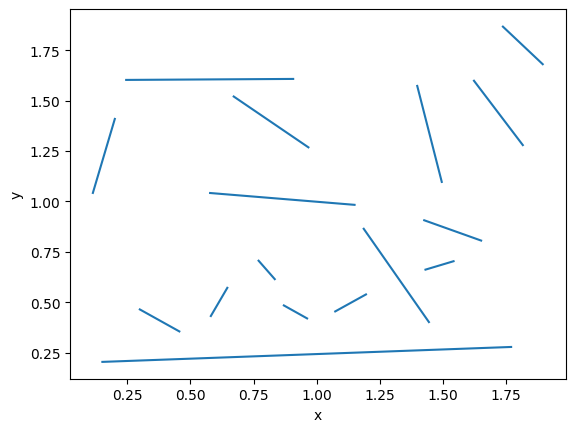

In [10]:
zbiorC=[((0.24153125860644464, 1.6025888185072978), (0.9107683833654642, 1.60754613054255)), ((1.6196640044064998, 1.6025888185072978), (1.8179564858165795, 1.2754062241806663)), ((0.14734232993665675, 0.20462682456623507), (1.7733406774993115, 0.278986505095015)), ((0.29606169099421653, 0.4673643624345909), (0.4596529881575325, 0.35334618562379494)), ((0.5786284770035804, 0.4277058661525749), (0.6480308454971083, 0.5764252272101348)), ((0.7670063343431562, 0.7102726521619387), (0.8364087028366841, 0.6111264114568987)), ((0.8661525750481961, 0.48719361057559885), (0.965298815753236, 0.41779124208207086)), ((1.0694023684935279, 0.4524924263288349), (1.1982924814100797, 0.5417240429633708)), ((1.4263288350316716, 0.6606995318094186), (1.5453043238777195, 0.7053153401266866)), ((1.4213715229964197, 0.9085651335720184), (1.6543651886532635, 0.8044615808317266)), ((0.5736711649683283, 1.0424125585238224), (1.153676673092812, 0.9829248141007985)), ((0.1126411456898927, 1.0374552464885705), (0.20187276232442863, 1.414210961167722)), ((0.6678600936381164, 1.523271825943266), (0.9702561277884881, 1.2654916001101622)), ((1.3965849628201599, 1.577802258331038), (1.4957312035251995, 1.0919856788763422)), ((1.7336821812172953, 1.8702836684109057), (1.8972734783806113, 1.676948499036078)), ((1.1834205453043238, 0.8689066372900025), (1.44615808317268, 0.3979619939410629))]
draw_only_intersect(zbiorC)
len(zbiorC)

Zbiór D: Częste sprawdzanie tych samych odcinków

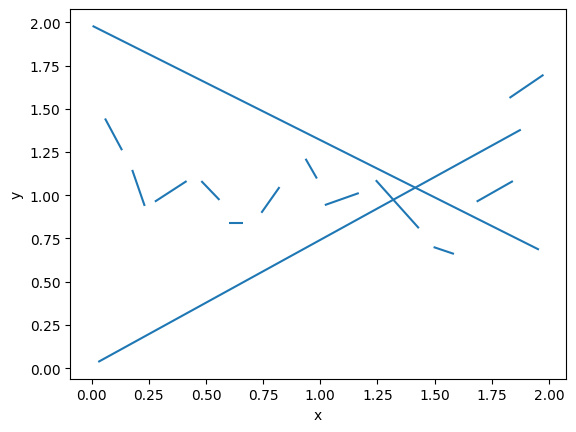

In [11]:
zbiorD=[((0.00358028091434881, 1.9793445331864497), (1.9567612228036353, 0.6854860919856787)), ((0.02836684109060883, 0.03607821536766723), (1.8774442302396035, 1.379509776920958)), ((0.05811071330212081, 1.443954833379234), (0.13247039383090076, 1.2605342880749102)), ((0.17708620214816873, 1.1465161112641142), (0.2316166345359406, 0.9383090057835304)), ((0.2762324428532086, 0.9630955659597904), (0.41503717984026445, 1.0820710548058383)), ((0.47948223629854037, 1.0820710548058383), (0.5587992288625724, 0.9730101900302945)), ((0.5984577251445883, 0.8391627650784905), (0.6629027816028642, 0.8391627650784905)), ((0.7422197741668962, 0.8986505095015145), (0.8215367667309282, 1.0473698705590744)), ((0.935554943541724, 1.2109611677223902), (0.985128063894244, 1.0969429909115944)), ((1.0198292481410078, 0.9432663178187826), (1.168548609198568, 1.0126686863123104)), ((1.2429082897273478, 1.0870283668410903), (1.4312861470669236, 0.8094188928669785)), ((1.4957312035251995, 0.7003580280914347), (1.5849628201597357, 0.6606995318094186)), ((1.6841090608647757, 0.9630955659597904), (1.8427430459928393, 1.0820710548058383)), ((1.8278711098870835, 1.562930322225282), (1.9765904709446431, 1.696777747177086))]
draw_only_intersect(zbiorD)

Potrzebne struktury danych

Opis class Point:
- self.x - współrzędna x'owa punktu
- self.y - współrzędna y'owa punktu
- self.label - etykieta danego punktu, która może być jedną ze zbioru {"begin","end","przeciecie"}
- self.attach_to - struktura (lub struktury) Section do której nalezy punkt 

Opis class Section:
- self.begin - punkt poczakowy odcinka
- self.end - punkt końcowy odcinka
- self.a - współczynnik kierunkowy prostej, który zawiera ten odcinek
- self.b - wyraz wolny prostej, który zawiera ten odcinek
- self.index_in_section - indeks w tablicy początkowej odcinków
- Section.x - zmienna statyczna opisująca aktualną pozycje miotły
- update_x(x) - zmienia aktualną pozycje miotły na x

In [ ]:

class Point:
    def __init__(self,x,y,label,section=None):
        self.x = x #współrzędna x-owa
        self.y = y #współrzędna y-owa
        self.label = label #etykieta punktu
        self.attach_to = section #przynależności do odcinka (odcinków)
        
    def __eq__(self,other): #przeciążenie operatora (==)
        if self.label=='przeciecie' or other.label=='przeciecie': return self.x==other.x and self.y==other.y
        # kiedy inicjalizuje Q chce mieć w niej wszystkie punkty
        else: return self.x==other.x and self.y==other.y and self.attach_to==other.attach_to
        
    def __gt__(self,other): #przeciążenie operatora (>)
        if self.x==other.x: return self.label>other.label
        return self.x>other.x
    
    def __hash__(self):
        return hash((self.x,self.y))
    
    def __str__(self):
        return f"Point(x={self.x}, y={self.y}, {self.label})"
    
    # wskaźnik do prostej, którą przechowuje
    def set_attach_to(self,section):
        self.attach_to = section
    
class Section:
    def __init__(self,begin, end, index_in_section=None):
        self.begin = begin #lewy koniec odcinka
        self.end = end #prawy koniec odcinka
        self.a = (self.begin.y-self.end.y)/(self.begin.x-self.end.x) #współczynnik nachylenia
        self.b = self.begin.y - self.a * self.begin.x #wyraz wolny
        self.index_in_section = index_in_section


    def update_x(x): #metoda statyczna (pole wspólne dla klasy)
        Section.x = x
        
    def __eq__(self,other):
        return (self.begin == other.begin and self.end == other.end)
    
    def __gt__(self,other):
        return self.a * Section.x + self.b > other.a * Section.x + other.b # jawnie obliczam y dla każdego punktu
    
    def __hash__(self):
        return hash((self.begin, self.end))
    
    def __str__(self):
        return f"begin: {self.begin}, end:{self.end})"

Uzupełnij funkcję ```is_intersection```

Funkcje pomocnicze

In [ ]:
eps=10**(-8)
def intersect_point(sect1,sect2):
    # wyznaczam punkt przecięcia obu prostych
    #pobieram dane
    if sect1.a == sect2.a: return None
    a1 = sect1.a
    b1 = sect1.b
    a2 = sect2.a
    b2 = sect2.b
    # jeżeli są równoległe
    if a1==a2: return
    x = (b1-b2)/(a2-a1)
    # sprawdzam, czy punkt jest w obrębie prostych
    if sect1.begin.x <= x <=sect1.end.x and sect2.begin.x<= x <=sect2.end.x:
        return (x,sect1.a*x+sect1.b)


In [ ]:
def is_intersection(sections):
    # inicjalizuje kolejke proirytetową w której trzymam punkty
    Q = []
    
    # Dodaje punkty do kolejki
    for begin_point, end_point in sections:
        section_of_this_points = Section( Point(begin_point[0],begin_point[1],'begin') , Point(end_point[0],end_point[1],'end'))
        # do każego punktu dodaje wskaźnik do jego odcinka
        Q.append(Point(begin_point[0],begin_point[1],'begin',section_of_this_points))
        Q.append(Point(end_point[0],end_point[1],'end',section_of_this_points))

    heapq.heapify(Q)
    
    # inicjalizuje pustą trukturę stanu
    T = SortedSet()
    
    while len(Q)>0:
        # pobieram punkt z kolejki i aktualizuje pozycje miotły
        actual_point = heapq.heappop(Q)
        Section.update_x(actual_point.x)
        actual_line = actual_point.attach_to
        # jeżeli punkt jest rozpoczynający
        if actual_point.label == "begin":
            # dodaje do struktury stanu i pobieram jego indeks
            T.add(actual_line)
            index = T.index(actual_line)
            # sprawdzam, czy się przecinają odpowienie odcinki
            if index>0 and intersect_point(actual_line,T[index-1]):
                return True
            if index < len(T)-1 and intersect_point(actual_line,T[index+1]):
                return True
        else:
            # pobieram indeks odcinka do którego należy rozpatrywany punkt
            index = T.index(actual_line)
            if 0<index<len(T)-1 and intersect_point(T[index-1],T[index+1]):
                return True
            # usuwam odcinke
            T.discard(actual_line)
    return False


In [178]:
Test().runtest(2, is_intersection)

Lab 4, task 2:
	Test 1: Passed
	Test 2: Passed
	Test 3: Passed
Result: 3/3
Time: 0.001s


Test dla zbiorów A,B,C i D

In [14]:
print("Zbiór A:", end="")
print(is_intersection(zbiorA))
print("Zbiór B:", end="")
print(is_intersection(zbiorB))
print("Zbiór C:", end="")
print(is_intersection(zbiorC))
print("Zbiór D:", end="")
print(is_intersection(zbiorD))

Zbiór A:True
Zbiór B:True
Zbiór C:False
Zbiór D:True


### W jaki sposób zaimplementowałeś struktura stanu (stan miotły) oraz struktura zdarzeń w Twoim programie?

Strukrtrę stanu zaimplementowałem za pomocą kolejki priorytetowej PriorityQueue() z biblioteki queue, zaś strukturę zdarzeń za pomocą SortedSet

Uzupełnij funkcję ```is_intersection_with_visualization```

In [ ]:
def get_beg_and_end_from_section(section):
    return ((section.begin.x,section.begin.y),(section.end.x,section.end.y))

def get_list_position_from_point(point):
    return point.x,point.y



def is_intersection_with_visualization(sections):
    section1=None
    section2=None
    def add_two_lines_on_vis(line1,line2):
        nonlocal section1,section2
        section1=vis.add_line_segment(get_beg_and_end_from_section(line1),color="yellow")
        section2=vis.add_line_segment(get_beg_and_end_from_section(line2),color="yellow")

    def delate_two_lines_on_vis():
        nonlocal section1,section2
        vis.remove_figure(section1)
        vis.remove_figure(section2)

    def color_line(section,color_):
        vis.add_point(get_list_position_from_point(section.begin),color=color_,s=25)
        vis.add_line_segment(get_beg_and_end_from_section(actual_line),color=color_)
        vis.add_point(get_list_position_from_point(section.end),color=color_,s=25)

    def czy_się_przecinaja_z_vis(line1,line2):
        add_two_lines_on_vis(line1,line2)
        if intersect_point(line1,line2):
            point=intersect_point(line1,line2)
            vis.add_point(point,color="red",s=35)
            return True
        delate_two_lines_on_vis()

     # tworze tablice przeystkich punktów
    vis = Visualizer()
    vis.clear()
    Q = []
    tab_of_point_to_draw=[]

    for begin_point, end_point in sections:
        section_of_this_points = Section( Point(begin_point[0],begin_point[1],'begin') , Point(end_point[0],end_point[1],'end'))
        # do każego punktu dodaje wskaźnik do jego odcinka
        Q.append(Point(begin_point[0],begin_point[1],'begin',section_of_this_points))
        Q.append(Point(end_point[0],end_point[1],'end',section_of_this_points))
        tab_of_point_to_draw.append(begin_point)
        tab_of_point_to_draw.append(end_point)

    heapq.heapify(Q)
    
    vis.add_point(tab_of_point_to_draw)
    vis.add_line_segment(sections)
    # inicjalizuje strukturę zdarzen
    
    T = SortedSet()
    n=len(sections)
    min_y=min([sections[i//2][i%2][0] for i in range(2*n)])
    max_y=max([sections[i//2][i%2][0] for i in range(2*n)])

    while len(Q)>0:
        actual_point = heapq.heappop(Q)
        actual_line = actual_point.attach_to
        broom=vis.add_line(((actual_point.x,min_y),(actual_point.x,max_y)),color="red")

        Section.update_x(actual_point.x-eps)
        
        if actual_point.label == "begin":
            color_line(actual_line,"lime")
            T.add(actual_line)
            index = T.index(actual_line)

            if index>0:
                if czy_się_przecinaja_z_vis(actual_line,T[index-1]):
                    return True,vis

            if index < len(T)-1:
                if czy_się_przecinaja_z_vis(actual_line,T[index+1]):
                    return True,vis
        else:
            index = T.index(actual_line)
            if 0<index<len(T)-1:
                if czy_się_przecinaja_z_vis(T[index-1],T[index+1]):
                    return True,vis

            T.discard(actual_line)
            color_line(actual_line,"black")
        vis.remove_figure(broom)
        vis.add_point((actual_point.x,actual_point.y),color='black')
    return False,vis


## Animacje wybranych zbiorów

Legenda kolorów obiektów prezentowanych na gif'ach:
- *kolor niebieski* - odcinki wraz z punktami początkowymi i końcowymi nieznajdujące się jeszcze w strukturze stanu
- *kolor zielony* - odcinki wraz z punktami początkowymi i końcowymi, które znajdują się aktualnie w strukturze stanu $T$
- *kolor czarny* - odcinki, które zostały usunięte z struktury stanu $T$ i punkty, który zostały już przetworzone
-*kolor żółty*- odcinki, których sprawdzamy przecięcie
- *kolor czerwony* - znalezione punkty przecięć odcinków

Zbiór A

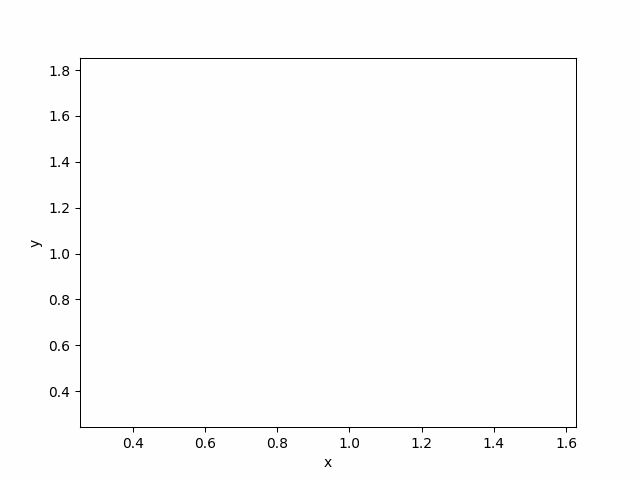

In [180]:
_,vis=is_intersection_with_visualization(zbiorA)
vis.show_gif(interval=200)

Zbiór B

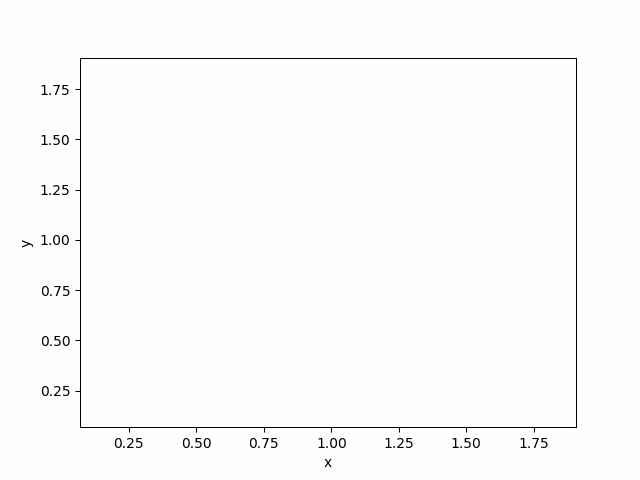

In [183]:
_,vis=is_intersection_with_visualization(zbiorB)
vis.show_gif(interval=200)

Zbiór C

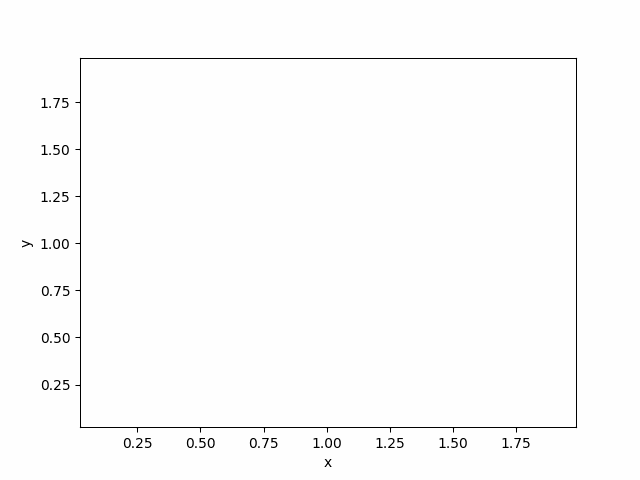

In [184]:
_,vis=is_intersection_with_visualization(zbiorC)
vis.show_gif(interval=200)

Zbiór D

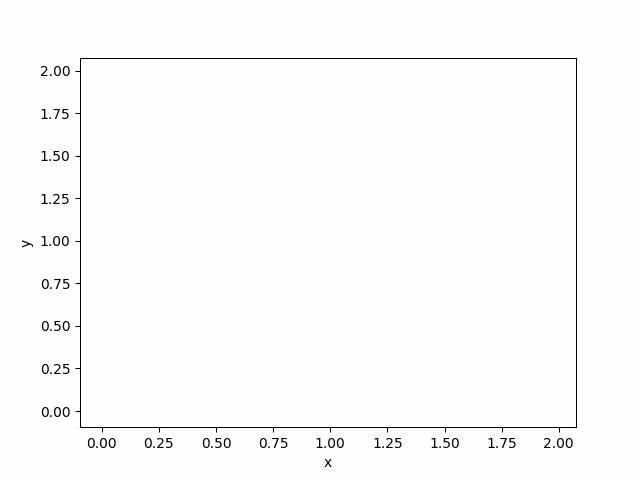

In [185]:
_,vis=is_intersection_with_visualization(zbiorD)
vis.show_gif(interval=200)

Uzupełnij funkcję ```find_intersections```

In [ ]:
vis=Visualizer()

def find_intersections(sections):
    def check_intersection_and_add_new_point_to_Q(line1,line2):
        # funkcja sprawdzająca przecięcie otrzymanych odcinków i dodające je
        # do struktury Q

        index_of_both_lines = (min(line1.index_in_section,line2.index_in_section)+1,max(line1.index_in_section,line2.index_in_section)+1)
        if index_of_both_lines not in already_checked:
            already_checked.add(index_of_both_lines)
            new_point = intersect_point(line1,line2)

            if new_point is not None and new_point[0]>actual_point.x: 
                # dodaje punkt do kolejki na miotle
                point_to_add = Point(new_point[0],new_point[1],'przeciecie',(line1,line2))
                # żeby cofnąć się do bazowej wartości
                heapq.heappush(Q,point_to_add)
                # korekcja ma na celu rozwiązać problem z przecięciami, które są równocześnie początkami odcinka
                # dodaje do tablicy wynikowej
                tab_przeciec.append(((new_point[0],new_point[1]),index_of_both_lines[0],index_of_both_lines[1]))

    # zbiór zbadanych już odcinków, dzięki temu nie rozpatruje pare razy tego samego punktu
    already_checked=set()
    # zbiór wynikowy
    tab_przeciec=[]
    # heapq jako struktura Q
    Q = []

    # inicjalizuje strukture punktów
    for index_in_section, (begin_point, end_point) in list(enumerate(sections)):
        section_of_this_points = Section( Point(begin_point[0],begin_point[1],'begin') , Point(end_point[0],end_point[1],'end'), index_in_section)
        Q.append(Point(begin_point[0],begin_point[1],'begin',section_of_this_points))
        Q.append(Point(end_point[0],end_point[1],'end',section_of_this_points))
    # utworzenie stosu
    heapq.heapify(Q)
    # inicjalizuje strukture stanu
    T = SortedSet()
    
    while len(Q)>0:
        actual_point = heapq.heappop(Q)
        actual_line = actual_point.attach_to
        # rozpatruje przypadek początku odcinka
        if actual_point.label == "begin":
            Section.update_x(actual_point.x)
            T.add(actual_line)
            index = T.index(actual_line)
            if index>0:
                check_intersection_and_add_new_point_to_Q(actual_line,T[index-1])

            if index < len(T)-1:
                check_intersection_and_add_new_point_to_Q(actual_line,T[index+1])

        # rozpatruje przypadek końca odcinka
        elif actual_point.label == "end":
            Section.update_x(actual_point.x)
            index = T.index(actual_line)
            if 0<index<len(T)-1:
                check_intersection_and_add_new_point_to_Q(T[index-1],T[index+1])
            T.discard(actual_line)
            
        # rozpatruje przypadek przecięcia odcinków
        else:
            # pobieram odcniki, które się przecinają w tym punkcie
            actual_line1, actual_line2 = actual_point.attach_to
            # przesuwam miotłe minimalnie przed aktualny punkt
            Section.update_x(actual_point.x-eps)
            # usuwam te odcinki
            T.discard(actual_line1)
            T.discard(actual_line2)
            # przesuwam miotłe minimalnie za aktualny punkt
            Section.update_x(actual_point.x+eps)
            # dodaje odcinki
            T.add(actual_line1)
            T.add(actual_line2)

            # wybieram, aby actual_line1 była wyżej niż actual_line2
            if actual_line1>actual_line2:
                index1 = T.index(actual_line1)
                index2 = T.index(actual_line2)
            else:
                index2 = T.index(actual_line1)
                index1 = T.index(actual_line2)
            
            # sprawdzam przecinanie się nowododanych lini
            if index1 < len(T)-1:
                check_intersection_and_add_new_point_to_Q(T[index1],T[index1+1])
            
            if index2>0:
                check_intersection_and_add_new_point_to_Q(T[index2],T[index2-1])

    
    return tab_przeciec

Funkcja do zwizualizowania wyników otrzymanych z find_intersection

In [39]:
def show_intersection(lines):
    vis.clear()
    vis.add_line_segment(lines)
    t=[]
    points=find_intersections(lines)
    for point,_,_ in points:
        t.append(point)
    vis.add_point(t,color="red")
    vis.show()
    print(len(points))

In [205]:
Test().runtest(3, find_intersections)

Lab 4, task 3:
	Test 1: Passed
	Test 2: Passed
	Test 3: Passed
Result: 3/3
Time: 0.002s


## wizualizacje znalezionych przecięć dla danych zbiorów

Zbiór A

5


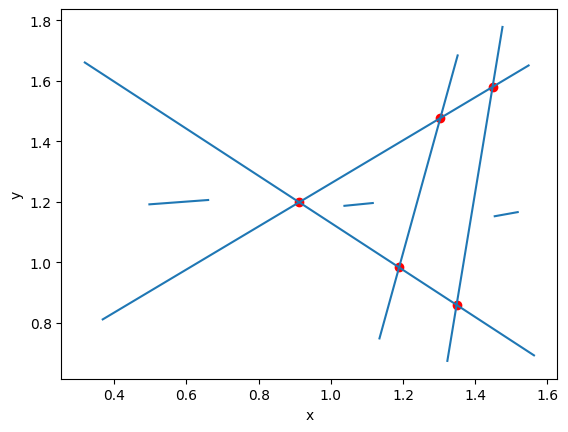

In [41]:
show_intersection(zbiorA)

Zbiór B

16


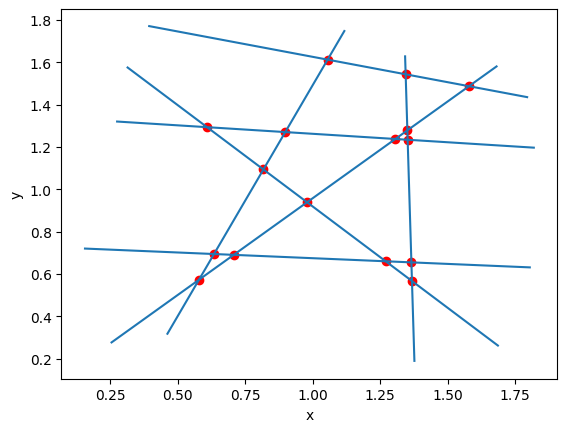

In [ ]:
show_intersection(zbiorB)

Zbiór C

0


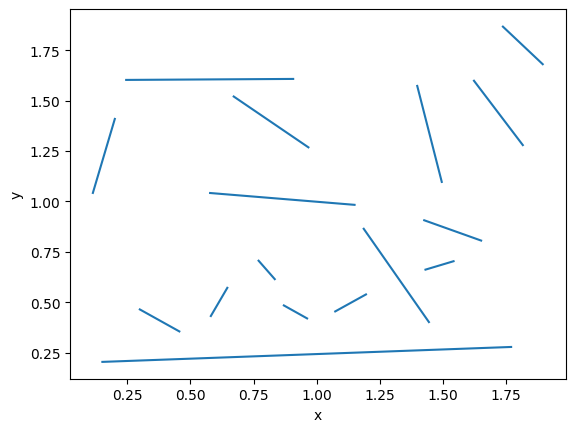

In [ ]:
show_intersection(zbiorC)

Zbiór D

2


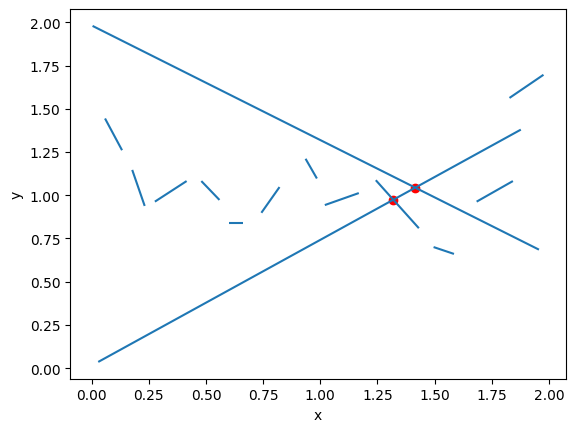

In [ ]:
show_intersection(zbiorD)

Uzupełnij funkcję ```find_intersections_with_visualization```

In [187]:
def find_intersections_with_visualization(sections):
    """
    Funkcja znajduje wszystkie przecięcia zadanych odcinków i dodatkowo zwraca kolejne kroki w wizualizacji 
    :param sections: tablica odcinków w postaci krotek ktorek współrzędnych punktów końcowych odcinków
    :return: tablica punktów przecięć w postaci trzyelementowych krotek w których pierwszym elementem są współrzędne danego punktu, a drugim i trzecim indeksy prostych z listy wejściowej, które się przecinają w tym punkcie współrzędnych np.:
    [((x1, y1), id1,id2),
    ((x2, y2), id3, id4),
    ...]
    """
    section1=None
    section2=None
    def add_two_lines_on_vis(line1,line2,_color):
        nonlocal section1,section2
        section1=vis.add_line_segment(get_beg_and_end_from_section(line1),color=_color)
        section2=vis.add_line_segment(get_beg_and_end_from_section(line2),color=_color)

    def delate_two_lines_on_vis():
        nonlocal section1,section2
        vis.remove_figure(section1)
        vis.remove_figure(section2)

    def color_line(section,color_):
        vis.add_point(get_list_position_from_point(section.begin),color=color_,s=25)
        vis.add_line_segment(get_beg_and_end_from_section(section),color=color_)
        vis.add_point(get_list_position_from_point(section.end),color=color_,s=25)

    def check_intersection_and_add_new_point_to_Q_and_draw(line1,line2):
        index_of_both_lines = (min(line1.index_in_section,line2.index_in_section)+1,max(line1.index_in_section,line2.index_in_section)+1)
        if index_of_both_lines not in already_checked:
            already_checked.add(index_of_both_lines)
            add_two_lines_on_vis(line1,line2,"yellow")
            new_point = intersect_point(line1,line2)
            if new_point is not None and new_point[0]>=actual_point.x: 
                vis.add_point(new_point,color="red",s=45)
                point_to_add = Point(new_point[0],new_point[1],'przeciecie',(line1,line2))
                heapq.heappush(Q,point_to_add)
                tab_przeciec.append(((new_point[0],new_point[1]),index_of_both_lines[0],index_of_both_lines[1]))
            delate_two_lines_on_vis()

    already_checked=set()
    tab_przeciec=[]
    Q = []
    vis = Visualizer()
    vis.clear()
    tab_of_point_to_draw=[]

    for index_in_section, (begin_point, end_point) in list(enumerate(sections)):
        section_of_this_points = Section( Point(begin_point[0],begin_point[1],'begin') , Point(end_point[0],end_point[1],'end'), index_in_section)
        Q.append(Point(begin_point[0],begin_point[1],'begin',section_of_this_points))
        Q.append(Point(end_point[0],end_point[1],'end',section_of_this_points))
        tab_of_point_to_draw.append(begin_point)
        tab_of_point_to_draw.append(end_point)
    heapq.heapify(Q)
    T = SortedSet()
    vis.add_point(tab_of_point_to_draw)
    vis.add_line_segment(sections)

    n=len(sections)
    min_y=min([sections[i//2][i%2][0] for i in range(2*n)])
    max_y=max([sections[i//2][i%2][0] for i in range(2*n)])
    
    while len(Q)>0:
        actual_point = heapq.heappop(Q)
        Section.update_x(actual_point.x-eps)
        actual_line = actual_point.attach_to
        broom=vis.add_line(((actual_point.x,min_y),(actual_point.x,max_y)),color="red")

        if actual_point.label == "begin":
            color_line(actual_line,"lime")

            T.add(actual_line)
            index = T.index(actual_line)
            if index>0:
                check_intersection_and_add_new_point_to_Q_and_draw(actual_line,T[index-1])

            if index < len(T)-1:
                check_intersection_and_add_new_point_to_Q_and_draw(actual_line,T[index+1])

        elif actual_point.label == "end":
            index = T.index(actual_line)
            if 0<index<len(T)-1:
                check_intersection_and_add_new_point_to_Q_and_draw(T[index-1],T[index+1])
            T.discard(actual_line)
            color_line(actual_line,"black")
        else:
            actual_line1, actual_line2 = actual_point.attach_to
            add_two_lines_on_vis(actual_line1,actual_line2,"black")
            T.discard(actual_line1)
            T.discard(actual_line2)
            Section.update_x(Section.x+2*eps)
            T.add(actual_line1)
            T.add(actual_line2)
            delate_two_lines_on_vis()
            if actual_line1>actual_line2:
                index1 = T.index(actual_line1)
                index2 = T.index(actual_line2)
            else:
                index2 = T.index(actual_line1)
                index1 = T.index(actual_line2)
            if index1 < len(T)-1:
                check_intersection_and_add_new_point_to_Q_and_draw(T[index1],T[index1+1])
            
            if index2>0:
                check_intersection_and_add_new_point_to_Q_and_draw(T[index2],T[index2-1])
        vis.remove_figure(broom)
        if actual_point.label != 'przeciecie':
            vis.add_point((actual_point.x,actual_point.y),color='black')
    
    return tab_przeciec,vis

### Czy konieczne były zmiany w strukturze zdarzeń. Jeśli tak, to jakie? Czy w przypadku obu algorytmów konieczne są takie same struktury zdarzeń?
### Odpowiedź uzasadnij. 

Nie zmieniłem struktury zdarzeń

### Jak obsługiwane są zdarzenia początku odcinka, końca odcinka i przecięcia odcinków z uwzględnianiem wybranych struktur danych?

Dla początku odcinka dodaje nowy odcinek do struktury T, a nastepnie sprawdzam przecięcie nowo dodanego odcinka z sąsiadami
Dla końca znajduje jego sąsiadów, usuwam przynależny do niego odcinek i sprawdzam przecięcie znalezionych sąsiadów
Dla przecięcia zdejmuje odcinki przecinające się w tym punkcie ze zbioru T i dodaje je ponownie. Następnie
sprawdzam przecięcie nowo dodanych odcinków z ich sąsiadami

## Animacje wybranych zbiorów

Zbiór A

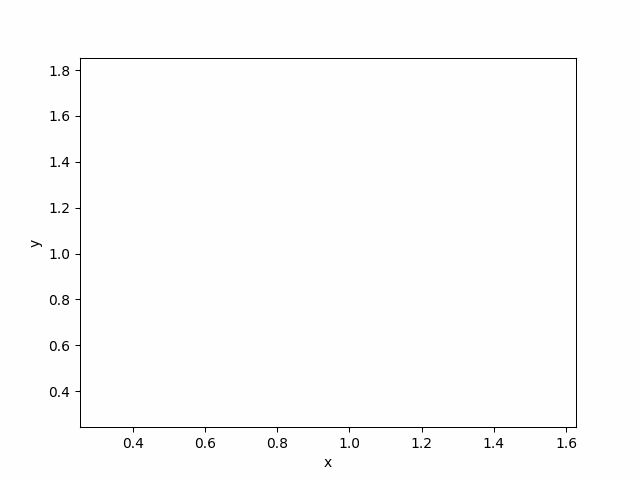

In [188]:
_,vis=find_intersections_with_visualization(zbiorA)
vis.show_gif(interval=200)

Zbiór B

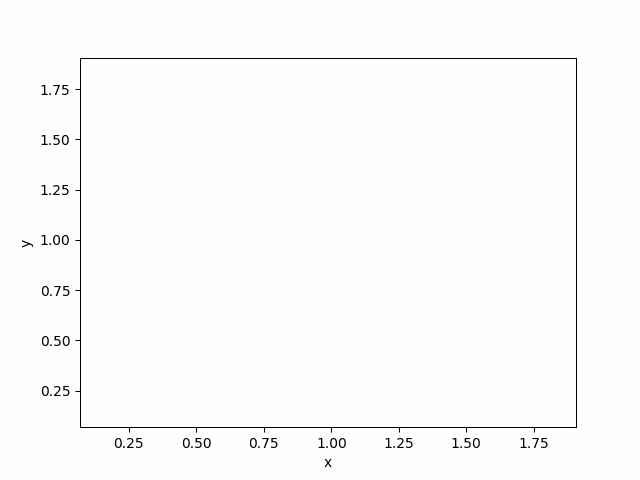

In [189]:
_,vis=find_intersections_with_visualization(zbiorB)
vis.show_gif(interval=200)

Zbiór C

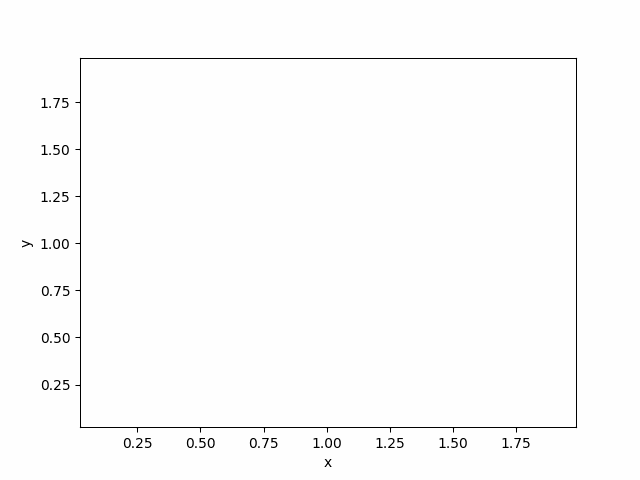

In [190]:
_,vis=find_intersections_with_visualization(zbiorC)
vis.show_gif(interval=200)

Zbiór D

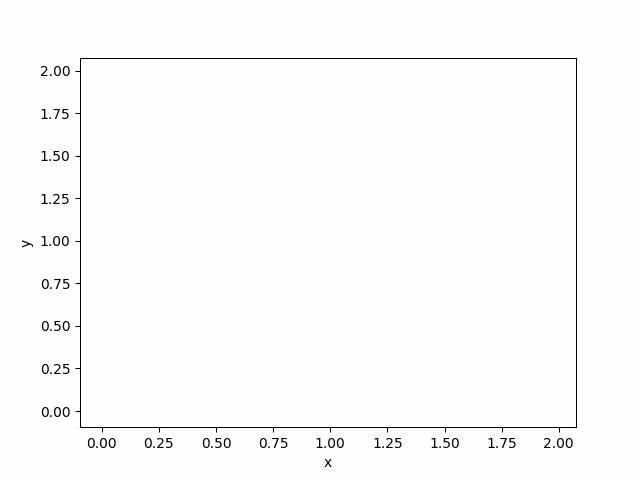

In [191]:
_,vis=find_intersections_with_visualization(zbiorD)
vis.show_gif(interval=200)

### Samemu zaprojektuj test, który uwzględnia taki układ odcinków, przy którym pewne przecięcia będą wykrywane więcej niż jeden raz

Ten przypadek jest uwzględniony dzięki strukturze Set() w której trzymam już sprawdzone pary odcinków

### Zadanie dodatkowe
Zaimplementuj inną strukturę stanu. Opisz ją w sprawozdaniu. Porównaj efektywność algorytmu dla obu struktur robiąc testy na odpowiednio dużych zestawach odcinków.

Zamieniłem strukturę stanu z SortedSet na tablice. Wykonuje wyszukiwania binarne dla przyspieszenia tego algorytmu

Funckje pomocnicze

In [32]:
def bsearch_left(t,val):
    p=0
    k=len(t)
    while p<k:
        i=(p+k)//2
        if t[i]<val:
            p=i+1
        elif t[i]>val:
            k=i
        else:
            return i
    return p

In [31]:
def add_to_tab(t,val):
    indeks=bsearch_left(t,val)
    if(indeks==len(t)):
        t.append(val)
    elif t[indeks]!=val:
            t.insert(indeks,val)
    return indeks

Algorytm na liście

In [294]:
def find_intersections_tab(sections):
    def check_intersection_and_add_new_point_to_Q(line1,line2):
        index_of_both_lines = (min(line1.index_in_section,line2.index_in_section)+1,max(line1.index_in_section,line2.index_in_section)+1)
        if index_of_both_lines not in already_checked:
            already_checked.add(index_of_both_lines)
            new_point = intersect_point(line1,line2)

            if new_point is not None and new_point[0]>=actual_point.x: 
                # dodaje punkt do kolejki na miotle
                point_to_add = Point(new_point[0],new_point[1],'przeciecie',(line1,line2))
                # żeby cofnąć się do bazowej wartości
                heapq.heappush(Q,point_to_add)
                # korekcja ma na celu rozwiązać problem z przecięciami, które są równocześnie początkami odcinka
                # dodaje do tablicy wynikowej
                tab_przeciec.append(((new_point[0],new_point[1]),index_of_both_lines[0],index_of_both_lines[1]))

    # zbiór zbadanych już odcinków, dzięki temu nie rozpatruje pare razy tego samego punktu
    already_checked=set()
    tab_przeciec=[]
    Q = []

    # inicjalizuje strukture punktów
    for index_in_section, (begin_point, end_point) in list(enumerate(sections)):
        section_of_this_points = Section( Point(begin_point[0],begin_point[1],'begin') , Point(end_point[0],end_point[1],'end'), index_in_section)
        Q.append(Point(begin_point[0],begin_point[1],'begin',section_of_this_points))
        Q.append(Point(end_point[0],end_point[1],'end',section_of_this_points))
    heapq.heapify(Q)
    # inicjalizuje strukture stanu
    T = []
    
    while len(Q)>0:
        actual_point = heapq.heappop(Q)
        actual_line = actual_point.attach_to

        # rozpatruje przypadek początku odcinka
        if actual_point.label == "begin":
            Section.update_x(actual_point.x)
            index = add_to_tab(T,actual_line)
            if index>0:
                check_intersection_and_add_new_point_to_Q(actual_line,T[index-1])

            if index < len(T)-1:
                check_intersection_and_add_new_point_to_Q(actual_line,T[index+1])

        # rozpatruje przypadek końca odcinka
        elif actual_point.label == "end":
            Section.update_x(actual_point.x)
            index = bsearch_left(T,actual_line)
            if 0<index<len(T)-1:
                check_intersection_and_add_new_point_to_Q(T[index-1],T[index+1])
            T.remove(actual_line)
            
        # rozpatruje przypadek przecięcia odcinków
        else:
            # pobieram odcniki, które się przecinają w tym punkcie
            actual_line1, actual_line2 = actual_point.attach_to
            #zamieniam
            Section.update_x(actual_point.x-eps)
            index1 = bsearch_left(T,actual_line1) 
            index2 = bsearch_left(T,actual_line2) 
            T[index1],T[index2] = T[index2],T[index1]
            Section.update_x(actual_point.x+eps)

            # wybieram, aby actual_line1 była wyżej niż actual_line2
            if actual_line1>actual_line2:
                index1,index2=index2,index1
            
            # sprawdzam przecinanie się nowododanych lini
            if index1 < len(T)-1:
                check_intersection_and_add_new_point_to_Q(T[index1],T[index1+1])
            
            if index2>0:
                check_intersection_and_add_new_point_to_Q(T[index2],T[index2-1])

    
    return tab_przeciec

Dodatek, imlementacja na drzewie avl, żeby porównać go z SortedSetem

In [ ]:

from bintrees import AVLTree
def print_sorted_set(cos):
    print("to sortedSet")
    for el in cos:
        print(el)
    print()
eps=10**(-8)
vis=Visualizer()

def find_intersections_avl(sections):
    def check_intersection_and_add_new_point_to_Q(line1,line2):
        index_of_both_lines = (min(line1.index_in_section,line2.index_in_section)+1,max(line1.index_in_section,line2.index_in_section)+1)
        if index_of_both_lines not in already_checked:
            already_checked.add(index_of_both_lines)
            new_point = intersect_point(line1,line2)

            if new_point is not None and new_point[0]>actual_point.x: 
                # dodaje punkt do kolejki na miotle
                point_to_add = Point(new_point[0],new_point[1],'przeciecie',(line1,line2))
                # żeby cofnąć się do bazowej wartości
                heapq.heappush(Q,point_to_add)
                # korekcja ma na celu rozwiązać problem z przecięciami, które są równocześnie początkami odcinka
                # dodaje do tablicy wynikowej
                tab_przeciec.append(((new_point[0],new_point[1]),index_of_both_lines[0],index_of_both_lines[1]))

    # zbiór zbadanych już odcinków, dzięki temu nie rozpatruje pare razy tego samego punktu
    already_checked=set()
    tab_przeciec=[]
    Q = []

    # inicjalizuje strukture punktów
    for index_in_section, (begin_point, end_point) in list(enumerate(sections)):
        section_of_this_points = Section( Point(begin_point[0],begin_point[1],'begin') , Point(end_point[0],end_point[1],'end'), index_in_section)
        Q.append(Point(begin_point[0],begin_point[1],'begin',section_of_this_points))
        Q.append(Point(end_point[0],end_point[1],'end',section_of_this_points))
    heapq.heapify(Q)
    # inicjalizuje strukture stanu
    T = AVLTree()
    
    while len(Q)>0:
        actual_point = heapq.heappop(Q)
        
        actual_line = actual_point.attach_to
        # rozpatruje przypadek początku odcinka
        if actual_point.label == "begin":
            Section.update_x(actual_point.x)
            T.insert(actual_line,actual_line)
            try:
                predecessor = T.prev_item(actual_line)[0]  
                check_intersection_and_add_new_point_to_Q(actual_line,predecessor)
            except KeyError: pass
            try:
                successor = T.succ_item(actual_line)[0]  
                check_intersection_and_add_new_point_to_Q(actual_line,successor)
            except KeyError: pass

        # rozpatruje przypadek końca odcinka
        elif actual_point.label == "end":
            Section.update_x(actual_point.x)
            try:
                successor = T.succ_item(actual_line)[0]  
                predecessor = T.prev_item(actual_line)[0]
                check_intersection_and_add_new_point_to_Q(predecessor,successor)
            except KeyError: pass
            T.remove(actual_line)
            
        # rozpatruje przypadek przecięcia odcinków
        else:
            # pobieram odcniki, które się przecinają w tym punkcie
            actual_line1, actual_line2 = actual_point.attach_to
            Section.update_x(actual_point.x-eps)
            # usuwam te odcinki
            T.remove(actual_line1)
            T.remove(actual_line2)
            # przesuwam miotłe minimalnie za aktualny punkt
            Section.update_x(actual_point.x+eps)
            # dodaje odcinki
            T.insert(actual_line1,actual_line1)
            T.insert(actual_line2,actual_line2)

            # wybieram, aby actual_line1 była wyżej niż actual_line2
            if actual_line1<actual_line2:
                actual_line1,actual_line2 = actual_line2, actual_line1
            
            # sprawdzam przecinanie się nowododanych lini
            try:
                successor = T.succ_item(actual_line1)[0]  
                check_intersection_and_add_new_point_to_Q(actual_line1,successor)
            except KeyError: pass
            
            try:
                predecessor = T.prev_item(actual_line2)[0] 
                check_intersection_and_add_new_point_to_Q(actual_line2,predecessor)
            except KeyError: pass

    
    return tab_przeciec

In [295]:
Test().runtest(3, find_intersections_tab)

Lab 4, task 3:
	Test 1: Passed
	Test 2: Passed
	Test 3: Passed
Result: 3/3
Time: 0.003s


Sprawdzenie poprawności algorytmu

In [27]:
print(find_intersections_tab(zbiorA)==find_intersections(zbiorA))
print(find_intersections_tab(zbiorB)==find_intersections(zbiorB))
print(find_intersections_tab(zbiorC)==find_intersections(zbiorC))
print(find_intersections_tab(zbiorD)==find_intersections(zbiorD))
# print(find_intersections_tab(zbior20)==find_intersections(zbior20))

True
True
True
True


Zebranie danych o czasie wykonania

Stała liczba przecięć

In [ ]:
from time import time
import matplotlib.pyplot as plt
tab_len=[50000,100000,200000,300000,400000,500000,600000,700000,800000,900000]
test_set = [generate_uniform_sections_same_length(i,i,i) for i in tab_len]
times_tab = [[0 for _ in range(3)] for _ in range(len(test_set))]
for i in range (len(test_set)):
   
    # SortedSet
    zbior_test=test_set[i]
    
    t0=time()
    v1=find_intersections(zbior_test)
    t1=time()
    times_tab[i][1] = t1-t0
    
    # List
    t0=time()
    v2=find_intersections_tab(zbior_test)
    t1=time()
    times_tab[i][2] = t1-t0

    # sprawdzenie czy te same wyniki
    if v1!=v2: times_tab[i][0] = "Błąd"
    else: times_tab[i][0] = len(v1)
        
df_b = pd.DataFrame(data = times_tab, columns=['liczba przecięć', 'SortedSet', 'Lista'], index=tab_len)
print(df_b)
print()
df_b.to_csv("Porównanie1.csv", index=True)

        liczba przecięć  SortedSet      Lista
50000             28085   2.889199   2.758290
100000            28365   5.918205   6.408724
200000            28398  11.560682  11.986465
300000            28756  16.581587  18.134461
400000            28659  21.339957  24.178964
500000            28725  25.342728  28.182350
600000            28891  30.717339  34.844394
700000            28692  37.154253  40.280139
800000            28559  41.628984  45.041640
900000            28523  47.943826  52.417418



kwadratowa liczba przecięć

In [ ]:
np.random.seed(33241)
from time import time
import matplotlib.pyplot as plt
tab_len=[250,500,1000,1500,2000,3000,4000,5000]
test_set = [generate_uniform_sections(100000,100000,i) for i in tab_len]
times_tab = [[0 for _ in range(3)] for _ in range(len(test_set))]
for i in range (len(test_set)):
   

    # SortedSet
    zbior_test=test_set[i]
    t0=time()
    v1=find_intersections(zbior_test)
    t1=time()
    times_tab[i][1] = t1-t0
    # List
    t0=time()
    v2=find_intersections_tab(zbior_test)
    t1=time()
    times_tab[i][2] = t1-t0
    
    # sprawdzenie czy te same wyniki
    if v1!=v2: times_tab[i][0] = "Błąd"
    else: times_tab[i][0] = len(v1)
        
df_b = pd.DataFrame(data = times_tab, columns=['liczba przecięć', 'SortedSet', 'Lista'], index=tab_len)
print(df_b)
print()
df_b.to_csv("Porównanie2.csv", index=True)

      liczba przecięć  SortedSet      Lista
250              5128   0.173104   0.106238
500             22128   0.535158   0.213906
1000            80083   2.234729   0.800161
1500           183612   4.994016   2.103146
2000           333890   9.453729   4.047603
3000           731639  21.395319   9.335527
4000          1347277  37.906153  17.604562
5000          2148696  63.182209  29.814554



dodatek: drzewo AVL

In [ ]:
from time import time
import matplotlib.pyplot as plt
tab_len=[50000,100000,200000,300000,400000,500000,600000,700000]
test_set = [generate_uniform_sections_same_length(i,i,i) for i in tab_len]
times_tab = [[0 for _ in range(3)] for _ in range(len(test_set))]
for i in range (len(test_set)):
   
    # AVL
    zbior_test=test_set[i]
    
    t0=time()
    v1=find_intersections_avl(zbior_test)
    t1=time()
    times_tab[i][1] = t1-t0
    
    # List
    t0=time()
    v2=find_intersections_tab(zbior_test)
    t1=time()
    times_tab[i][2] = t1-t0

    # sprawdzenie czy te same wyniki
    if v1!=v2: times_tab[i][0] = "Błąd"
    else: times_tab[i][0] = len(v1)
    print(len(zbior_test))
        
df_b = pd.DataFrame(data = times_tab, columns=['liczba przecięć', 'avl', 'Lista'], index=tab_len)
print(df_b)
print()
df_b.to_csv("Porównanie_avl.csv", index=True)

50000
100000
200000
300000
400000
500000
600000
700000
        liczba przecięć        avl      Lista
50000             28593   4.114172   7.636081
100000            28796   7.408724   5.308491
200000            28382  13.807971  10.527707
300000            28657  22.028975  16.111990
400000            28502  26.914843  20.412389
500000            28721  33.154419  23.260961
600000            29025  36.715170  29.499872
700000            28697  43.965225  32.981965



Dla implementacji opartej na drzewo AVL czas okazał się gorszy niż dla SortedSet. Kształt wykresu czasu wykonania do ilości odcinków jest taki sam jak dla SortedSet